In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Subsetting

This time, I want to subset the SASAP Kuskokwim region. The Kusko SASAP region seems to be made up of HUCs starting with $190304$ and $190305$.

<img src="images/Kusko_sasap.png" width="700px"/>


In [10]:
import geopandas as gpd

In [10]:
gdb_fp = '/Users/jkibele/Documents/SASAP/gis/data_USGS/NHDH_AK.gdb'

Check the layer names with `ogrinfo`.

In [11]:
!ogrinfo $gdb_fp

Had to open data source read-only.
INFO: Open of `/Users/jkibele/Documents/SASAP/gis/data_USGS/NHDH_AK.gdb'
      using driver `OpenFileGDB' successful.
1: ExternalCrosswalk (None)
2: NHDFCode (None)
3: NHDFeatureToMetadata (None)
4: NHDFlow (None)
5: NHDFlowlineVAA (None)
6: NHDMetadata (None)
7: NHDProcessingParameters (None)
8: NHDReachCodeMaintenance (None)
9: NHDReachCrossReference (None)
10: NHDSourceCitation (None)
11: NHDStatus (None)
12: NHDVerticalRelationship (None)
13: NHDPoint (Point)
14: NHDFlowline (Multi Line String)
15: NHDLine (Multi Line String)
16: NHDArea (Multi Polygon)
17: NHDWaterbody (Multi Polygon)
18: NHDAreaEventFC (Multi Polygon)
19: NHDLineEventFC (Multi Line String)
20: NHDPointEventFC (Point)
21: WBDLine (Multi Line String)
22: NonContributingDrainageArea (Multi Polygon)
23: NWISBoundary (Multi Line String)
24: NWISDrainageArea (Multi Polygon)
25: WBDHU14 (Multi Polygon)
26: WBDHU8 (Multi Polygon)
27: WBDHU2 (Multi Polygon)
28: WBDHU4 (Multi Polygon)
29:

### Subset the Flowlines

In [12]:
%%time
flowlines = gpd.read_file(gdb_fp, layer="NHDFlowline")

CPU times: user 9min 15s, sys: 21.8 s, total: 9min 37s
Wall time: 9min 41s


In [13]:
len(flowlines)

2505422

Turns out there's one record with a `Null` ReachCode. I'll drop that.

In [14]:
flowlines.dropna(subset=['ReachCode'], inplace=True)

In [15]:
len(flowlines)

2505421

In [16]:
hucs = ['190304','190305']
# convert to str in case it's numeric
kusko_huc = lambda s: str(s)[:6] in hucs

In [17]:
%%time
kusko_flowlines = flowlines[flowlines.ReachCode.apply(kusko_huc)]

CPU times: user 1.61 s, sys: 57.6 ms, total: 1.67 s
Wall time: 1.65 s


In [18]:
len(kusko_flowlines)

286528

In [65]:
kusko_flowlines.crs

{'init': u'epsg:4269'}

Convert to Alaska Albers projection and save these lines to a shapefile.

In [19]:
%%time
kusko_flowlines.to_crs(epsg=3338).to_file('data/kusko_region_flowlines.shp')

CPU times: user 4min 16s, sys: 1.89 s, total: 4min 18s
Wall time: 4min 19s


**Problem:** Upon very close inspection, I found there was at least one 2cm gap in the Kuskokwim river. It was where the reach code switched from 19030501000001 to 19030502071127. In other words, it was on the border of a HUC. This, of course, caused problems with finding a path to the coast because that path was broken. To fix it, I used `v.clean` from Grass with a 2.0 m snap tolerance. This seems to have fixed the problem.

### Prune the Network

In [12]:
from graph_prep import GraphBuilder
from river_graph import RiverGraph, point_to_tuple

In [3]:
%%time
gb = GraphBuilder('data/kusko_region_flowlines_snap.shp')

CPU times: user 51.7 s, sys: 1.87 s, total: 53.6 s
Wall time: 53.3 s


In [4]:
len(gb.graph)

277411

In [5]:
%%time
gb.graph = gb.prune_network(True)

99 graphs with coastal nodes, 5449 without.
CPU times: user 9min 51s, sys: 19.3 s, total: 10min 10s
Wall time: 10min 7s


In [6]:
len(gb.graph)

230859

In [7]:
import networkx as nx

In [8]:
%%time
# nx.write_shp(gb.graph, 'data/kusko_pruned3/')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


### Test 

In [72]:
starts = gpd.read_file('data/test_points_region.shp')

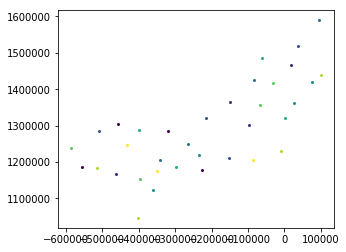

In [73]:
starts.plot()

In [74]:
%%time
paths = starts.geometry.apply(lambda g: gb.graph.shortest_path_to_coast(
                                   gb.graph.closest_node(tuple(np.array(g.coords)[0]))))

CPU times: user 14.9 s, sys: 243 ms, total: 15.2 s
Wall time: 15.3 s


In [75]:
deadend_start = (-227183.49276647705, 1177703.0441095252)
deadend = gb.graph.closest_node((-290938, 1301283))

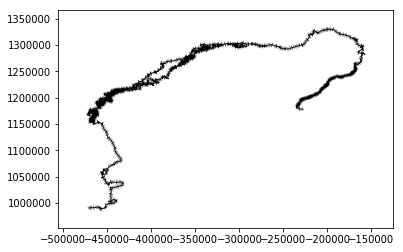

In [76]:
gb.graph.reachable_subgraph(deadend_start).plot()

In [77]:
pgdf = gpd.geodataframe.GeoDataFrame(paths)
pgdf.crs = starts.crs
pgdf.to_file('data/test_paths_region.shp')

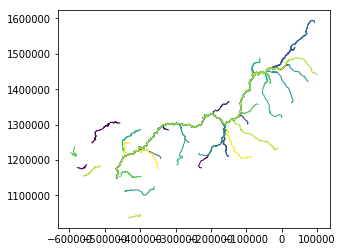

In [78]:
pgdf.plot()

### Jorge's Locations

In [79]:
jorge = gpd.read_file('data/positions/kusko_pos.shp')

In [84]:
jorge.crs

{'init': u'epsg:4326'}

In [85]:
jorge.to_crs(epsg=3338, inplace=True)

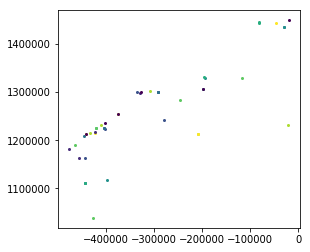

In [86]:
jorge.plot()

Location $26$ is right on a coastline edge so it doesn't return a path. I need to handle that case, but for now I'm just going to omit that point.

In [200]:
jorge.query('field_1 != 26', inplace=True)

In [201]:
# %%time
jorge['path'] = jorge.geometry.apply(lambda g: gb.graph.shortest_path_to_coast(
                                   gb.graph.closest_node(tuple(np.array(g.coords)[0]))))

In [219]:
jorge['river_km'] = jorge.path.apply(lambda g: g.length * 0.001)

In [220]:
jorge.set_geometry('path', drop=True).to_file('data/cornejo_kusko.shp')

#### Mess with the coastal start point

In [13]:
badpnt = gpd.read_file('data/positions/kusko_pos.shp').to_crs(epsg=3338).query('field_1 == 26')
n0 = point_to_tuple(badpnt)

In [14]:
gb.graph.is_coastal_node(n0)

False

In [15]:
gb.graph.shortest_path_to_coast(n0)

TypeError: not all arguments converted during string formatting

In [16]:
n0

(-443121.8744479866, 1110822.1130469847)

In [17]:
ed = gb.graph.edges(n0)

In [18]:
ed

[]